<a href="https://colab.research.google.com/github/MeysamAmirsardari/PoseModel/blob/main/Jupyter%20Notebook/PennActionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations:

In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports:

In [3]:
import torch_geometric
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as Data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
#from torch_geometric.data import HeteroData

In [3]:
import numpy as np
import torch
import pandas as pd
import os
import scipy.io

In [4]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Loading the data:

In [12]:
import os
import urllib.request
import tarfile


dataset_url = "https://www.cis.upenn.edu/~kostas/Penn_Action.tar.gz"
dataset_path = "/content/pennaction"

os.makedirs(dataset_path, exist_ok=True)

urllib.request.urlretrieve(dataset_url, "/content/pennaction.tar.gz")

with tarfile.open("/content/pennaction.tar.gz", "r:gz") as tar_ref:
    tar_ref.extractall(dataset_path)

print("Penn Action Dataset has been successfully downloaded and extracted.")
print("Dataset files are located at:", dataset_path)

Penn Action Dataset has been successfully downloaded and extracted.
Dataset files are located at: /content/pennaction


In [13]:
directory = "/content/pennaction/Penn_Action/labels"

Xs = []
Ys = []

for filename in os.listdir(directory):
    if filename.endswith(".mat"):
        # Load .mat file
        mat_data = scipy.io.loadmat(os.path.join(directory, filename))

        # Extract X and Y coordinates from the .mat file
        x = mat_data['x']
        y = mat_data['y']

        # Append X and Y coordinates to the concatenated lists
        Xs.append(x)
        Ys.append(y)

# Concatenate the X and Y coordinates along the frames axis
Xs = np.concatenate(Xs)
Ys = np.concatenate(Ys)

# Create DataFrames for X and Y coordinates
df_x = pd.DataFrame(Xs)
df_y = pd.DataFrame(Ys)

# Save X and Y coordinates as CSV files
df_x.to_csv("/content/drive/MyDrive/Behavioral/concatenated_x.csv", index=False)
df_y.to_csv("/content/drive/MyDrive/Behavioral/concatenated_y.csv", index=False)

del df_y
del df_x

# Modeling the graph:

In [14]:
Xs_cov = np.corrcoef(Xs.T)
Ys_cov = np.corrcoef(Ys.T)
edj_attr_matrix = (np.square(Ys_cov) + np.square(Xs_cov))/2
print(edj_attr_matrix.astype(np.double))

[[1.         0.29750833 0.28465865 0.34479813 0.31146237 0.22186764
  0.21164462 0.13160681 0.1077938  0.06580145 0.04055456 0.03064238
  0.02222608]
 [0.29750833 1.         0.16880615 0.36651992 0.15292109 0.40423099
  0.19630338 0.4108862  0.051547   0.16811322 0.05833339 0.08392606
  0.03203224]
 [0.28465865 0.16880615 1.         0.14673664 0.34069436 0.18246727
  0.31718169 0.0456181  0.34166631 0.01088467 0.07871219 0.01227133
  0.04644033]
 [0.34479813 0.36651992 0.14673664 1.         0.3394987  0.52451109
  0.27328059 0.27987516 0.06881943 0.17225069 0.06877518 0.08730287
  0.04064895]
 [0.31146237 0.15292109 0.34069436 0.3394987  1.         0.25736793
  0.53684787 0.08738224 0.21034251 0.03399027 0.10414943 0.01496172
  0.0375876 ]
 [0.22186764 0.40423099 0.18246727 0.52451109 0.25736793 1.
  0.40212926 0.20751235 0.07357617 0.09872006 0.06062903 0.06344254
  0.03776645]
 [0.21164462 0.19630338 0.31718169 0.27328059 0.53684787 0.40212926
  1.         0.08482643 0.15999178 0.028

In [15]:
def get_edge_idx(num_layers, num_landmarks = 13):
  edge_index = []
  edge_attr = []
  # Connect each landmark to all other landmarks in the same layer
  for layer in range(num_layers):
      start = layer * num_landmarks
      layer_edges = [(i, j) for i in range(start, start + num_landmarks) for j in range(start, start + num_landmarks) if i != j]
      layer_edges = [[edge[0], edge[1]] for edge in layer_edges]
      edge_index.extend(layer_edges)
      edge_attr.extend([edj_attr_matrix[i % num_landmarks, j % num_landmarks] for i, j in layer_edges])

  # Connect each landmark to the same landmark in the next layer
  for layer in range(num_layers - 1):
      start1 = layer * num_landmarks
      start2 = (layer + 1) * num_landmarks
      layer_edges = [[i, j] for i in range(start1, start1 + num_landmarks) for j in range(start2, start2 + num_landmarks) if i % num_landmarks == j % num_landmarks]
      edge_index.extend(layer_edges)
      edge_attr.extend([1 for _ in layer_edges])
      
  edge_index = torch.tensor(edge_index).double().t().contiguous()
  edge_attr = torch.tensor(edge_attr).unsqueeze(-1)
  return edge_index, edge_attr

In [16]:
action_map = {
    "baseball_pitch": 0,
    "clean_and_jerk": 1,
    "pull_ups": 2,
    "pullup": 2,
    "strumming_guitar": 3,
    "strum_guitar": 3,
    "baseball_swing": 4,
    "golf_swing": 5,
    "push_ups": 6,
    "pushup": 6,
    "tennis_forehand": 7,
    "bench_press": 8,
    "jumping_jacks": 9,
    "sit_ups": 10,
    "situp": 10,
    "tennis_serve": 11,
    "bowling": 12,
    "bowl": 12,
    "jump_rope": 13,
    "squat": 14,
    "squats": 14
}

In [17]:
def set_nodes(Xs, Ys, CLs, nframes, land_mark_num=13):
  x = torch.tensor([])

  for i in range(nframes):
    for n in range(land_mark_num):
      step = torch.tensor([[float(Xs[i, n])], 
                           [float(Ys[i, n])], 
                           [float(CLs[i, n])]],
                          dtype=torch.float)
      x = torch.cat((x, step.T), dim=0)
  return x

In [18]:
from torch_geometric.data import Data

directory = "/content/pennaction/Penn_Action/labels"

graph_list = []
label_list = []
nframes_list = []
pose_list = []


for filename in os.listdir(directory):
    if filename.endswith(".mat"):
        # Load .mat file
        mat_data = scipy.io.loadmat(os.path.join(directory, filename))
        
        # Extract relevant information from the .mat file
        x = np.array(mat_data['x'], dtype=np.float32)
        y = np.array(mat_data['y'], dtype=np.float32)
        visibility = np.array(mat_data['visibility'], dtype=np.float32)
        bbox_w = np.array(mat_data['bbox'][:, 2], dtype=np.float32)
        bbox_h = np.array(mat_data['bbox'][:, 3], dtype=np.float32)
        
        # Calculate the weighted mean for X_norm and Y_norm
        x_mean = np.sum(x * visibility, axis=1) / np.sum(visibility, axis=1)
        y_mean = np.sum(y * visibility, axis=1) / np.sum(visibility, axis=1)
        
        if len(bbox_h) != x.shape[0]:
          continue

        x_norm = (x - np.expand_dims(x_mean, axis=1)) / bbox_w[:, np.newaxis]
        y_norm = (y - np.expand_dims(y_mean, axis=1)) / bbox_h[:, np.newaxis]

        x_norm = torch.tensor(x_norm, dtype=torch.float)
        y_norm = torch.tensor(y_norm, dtype=torch.float)
        visibility = torch.tensor(visibility, dtype=torch.float)

        # node_features = torch.cat([x_norm, y_norm, visibility], dim=1)
        nframes = int(mat_data['nframes'])

        node_features = set_nodes(x_norm, y_norm, visibility, nframes, land_mark_num=13)
        
        edge_index, edge_attr = get_edge_idx(nframes)
        y = action_map[mat_data['action'][0]]
        label_list.append(y)
        nframes_list.append(nframes)
        pose_list.append(mat_data['pose'])

        # Create the Data object
        # data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=y)
        # graph_list.append(data)

# Convert the list of Data objects to a PyTorch Geometric dataset
# dataset = torch_geometric.data.InMemoryDataset(graph_list)

<ipython-input-18-bbee8fc400cf>:24: RuntimeWarning: invalid value encountered in true_divide
  x_mean = np.sum(x * visibility, axis=1) / np.sum(visibility, axis=1)
<ipython-input-18-bbee8fc400cf>:25: RuntimeWarning: invalid value encountered in true_divide
  y_mean = np.sum(y * visibility, axis=1) / np.sum(visibility, axis=1)
<ipython-input-18-bbee8fc400cf>:24: RuntimeWarning: invalid value encountered in true_divide
  x_mean = np.sum(x * visibility, axis=1) / np.sum(visibility, axis=1)
<ipython-input-18-bbee8fc400cf>:25: RuntimeWarning: invalid value encountered in true_divide
  y_mean = np.sum(y * visibility, axis=1) / np.sum(visibility, axis=1)
<ipython-input-18-bbee8fc400cf>:24: RuntimeWarning: invalid value encountered in true_divide
  x_mean = np.sum(x * visibility, axis=1) / np.sum(visibility, axis=1)
<ipython-input-18-bbee8fc400cf>:25: RuntimeWarning: invalid value encountered in true_divide
  y_mean = np.sum(y * visibility, axis=1) / np.sum(visibility, axis=1)
<ipython-input-1

* **Create and save the dataset:**

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

loader = DataLoader(graph_list, batch_size=16)
torch.save(loader, '/content/drive/MyDrive/Behavioral/PennActionGraphs.pth')

# pd.DataFrame(order).to_csv('/content/drive/MyDrive/order.csv')

In [ ]:
dataloader = DataLoader(dataset, batch_size=16)

# Training the Attentional Variational Graph Autoencoder:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.utils import to_dense_adj

device = torch.device('cpu')

class VGAEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VGAEModel, self).__init__()
        self.encoder = GCNConv(input_dim, hidden_dim, normalize=True)
        self.decoder = InnerProductDecoder()

        self.vgae = VGAE(self.encoder, self.decoder)

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.decoder.reset_parameters()

    def forward(self, x, edge_index):
        return self.vgae(x, edge_index)

class InnerProductDecoder(torch.nn.Module):
    def forward(self, z):
        adj = torch.sigmoid(torch.matmul(z, z.t()))
        return adj

def loss_function(pred_adj, adj):
    bce_loss = F.binary_cross_entropy_with_logits(pred_adj, adj)
    kld_loss = -0.5 * torch.mean(1 + 2 * std - mu.pow(2) - std.exp())
    return bce_loss + kld_loss

# Example usage:
# Assume you have your input features `x` and adjacency matrix `adj` in the correct format.

# Set hyperparameters
input_dim = 3  # Dimensionality of input features
hidden_dim = 64  # Dimensionality of hidden layer
latent_dim = 32  # Dimensionality of latent space

# Create the VGAE model
model = VGAEModel(input_dim, hidden_dim, latent_dim).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# loss_fn = model.vgae.loss

import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []
graph_num = 2324
num_epochs = 100

dataloader = DataLoader(graph_list, batch_size=32, shuffle=True)

# device = torch.device('cpu')

# Define the optimizer for the VAE
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Train the VAE model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for batch in dataloader:
        model.train()
        batch = batch.to(device)
        optimizer.zero_grad()
        adj = to_dense_adj(batch.edge_index.long())[0]
        mu = model(batch.x, batch.edge_index.long())
        pred_adj = model.decoder(mu)
        loss = loss_function(pred_adj, adj)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs
    train_loss /= graph_num
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item()}')
    loss_list.append(loss.item())


In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, TransformerConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np

# Define the number of epochs to train for
num_epochs = 200

# Define the batch size for the dataloader
batch_size = 32

# Define the number of nodes and features in each node
# num_nodes = 2160
num_features = 3

# Define the number of dimensions in the latent variable
hidden_dim = 32
output_dim = 24
input_dim = 3

# Define the device to use for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder and decoder architectures for the VAE

class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gmm_layers=0):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)
        # self.gmm_layers = torch.nn.ModuleList()
        # for i in range(num_gmm_layers):
        #     self.gmm_layers.append(GMMConv(hidden_dim, hidden_dim, kernel_size=25, dim=3))
        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gat1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat2(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat3(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        # for gmm_layer in self.gmm_layers:
        #     x = gmm_layer(x, edge_index, edge_attr)
        #     x = F.elu(x)
        #     x = F.dropout(x, p=0.4, training=self.training)

        # x = global_add_pool(x, batch)
        # x, batch = to_dense_batch(x, batch=batch)
        
        x = self.conv_mu(x, edge_index)

        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)

        # z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std

class Decoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index, edge_attr):
        z = self.lin1(z)
        z = F.relu(z)
        z = self.conv1(z, edge_index)
        z = F.relu(z)
        z = self.conv2(z, edge_index)
        z = F.relu(z)
        z = self.lin2(z)
        z = F.relu(z)
        z = self.conv3(z, edge_index)
        z = F.relu(z)
        z = self.lin3(z)
        z = torch.sigmoid(z)
        return z


class AttentionalGraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionalGraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, output_dim)
        self.decoder = Decoder(output_dim, hidden_dim, input_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        z, z_mean, z_log_std = self.encoder(x, edge_index, edge_attr, batch)
        z = z_mean + torch.randn_like(z_log_std) * torch.exp(0.5 * z_log_std)
        x_hat = self.decoder(z, edge_index, edge_attr)
        return x_hat, z_mean, z_log_std

def loss_function(x_hat, z_mean, x, z_log_std):
    # kl_loss = 0#0.5 * torch.sum(z_log_std - output**2 - 1, dim=1)
    kl_loss = -0.5 * torch.sum(1 + z_log_std - z_mean.pow(2) - z_log_std.exp())
    recon_loss = F.mse_loss(x_hat, x)
    print(kl_loss)
    print(recon_loss)
    loss = recon_loss + 0.1*kl_loss
    return loss
# def loss_function(x_hat, x, z_mean, z_log_std, alpha):
#     kl_loss = 0.5 * torch.sum(z_log_std + torch.exp(z_log_std) - z_mean**2 - 1, dim=1)
#     recon_loss = F.mse_loss(x_hat, x)
#     loss = recon_loss + alpha * kl_loss
#     return loss

def kl_loss(z_mean, z_log_std):
    kl_div = -0.5 * torch.sum(1 + 2*z_log_std - z_mean.pow(2) - (2*z_log_std).exp(), dim=1)
    return torch.mean(kl_div)


class GraphClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphClassifier, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, 24)
        self.lin1 = torch.nn.Linear(32, 128)
        self.lin_out = torch.nn.Linear(128, 15)

    def forward(self, x, edge_index, edge_attr, batch):
        # x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        z = self.encoder(x, edge_index, edge_attr, batch)
        # print(z.shape)
        z = self.lin1(z)
        z = self.lin_out(z)
        return z

In [113]:
from sklearn.model_selection import train_test_split

# Assuming your list is called 'data'
# Split the data into train (80%), validation (10%), and test (10%) sets
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [123]:
import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []
graph_num = 2324

dataloader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)

# Initialize the attentional graph autoencoder model and move it to the device
# model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)
model = GraphClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer for the VAE
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the VAE model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # edge_index = utils.batched_edge_indices(batch.edge_index, batch.batch).to(device)
        # x_hat, z_mean, z_log_std = model(torch.nan_to_num(batch.x, nan=0.0), batch.edge_index.long(), torch.nan_to_num(batch.edge_attr, nan=0.0), batch.batch)
        z = model(torch.nan_to_num(batch.x, nan=0.0), batch.edge_index.long(), torch.nan_to_num(batch.edge_attr, nan=0.0), batch.batch)
        # loss = loss_function(x_hat, z_mean, batch.x, z_log_std)
        # loss = loss_function(x_hat, batch.x, z_mean, z_log_std, alpha)
        # loss = F.mse_loss(x_hat, torch.nan_to_num(batch.x, nan=0.0))
        # print(kl_loss(z_mean, z_log_std))
        # print(kl_loss(z_mean, z_log_std))
        # loss = loss + 0.99 * kl_loss(z_mean, z_log_std)

        loss = criterion(z, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs

    for batch in val_loader:
        batch = batch.to(device) 
        z = model(torch.nan_to_num(batch.x, nan=0.0), batch.edge_index.long(), torch.nan_to_num(batch.edge_attr, nan=0.0), batch.batch)
        vloss = criterion(z, batch.y)
        val_loss += vloss.item() * batch.num_graphs

    train_loss /= graph_num*0.8
    val_loss /= graph_num*0.1
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss={train_loss}, Val Loss={val_loss}')
    loss_list.append(loss.item())

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/200: Train Loss=2.166660624250077, Val Loss=2.29927753827658
Epoch 2/200: Train Loss=1.8822949513049216, Val Loss=2.078738925071263
Epoch 3/200: Train Loss=1.7688147969890173, Val Loss=2.0647853428238228
Epoch 4/200: Train Loss=1.7287841305880456, Val Loss=1.9287243172552007
Epoch 5/200: Train Loss=1.693382525941591, Val Loss=2.0076264982174266
Epoch 6/200: Train Loss=1.6762895371745663, Val Loss=1.865585507911577
Epoch 7/200: Train Loss=1.6674452245543212, Val Loss=1.9471470691045671
Epoch 8/200: Train Loss=1.6426874747220908, Val Loss=1.840821840061378
Epoch 9/200: Train Loss=1.624705034873982, Val Loss=1.7405747474778746
Epoch 10/200: Train Loss=1.5950841197612569, Val Loss=1.8099129410290677
Epoch 11/200: Train Loss=1.5945535745606365, Val Loss=1.8581666408840842
Epoch 12/200: Train Loss=1.6018254657415432, Val Loss=1.8030398494200124
Epoch 13/200: Train Loss=1.5838867492601916, Val Loss=1.7902653886200843
Epoch 14/200: Train Loss=1.5697579028120139, Val Loss=1.820670715092

KeyboardInterrupt: ignored

In [124]:
def evaluate(model, data_loader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            batch.to(device)
            # inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(torch.nan_to_num(batch.x, nan=0.0), batch.edge_index.long(), torch.nan_to_num(batch.edge_attr, nan=0.0), batch.batch)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += batch.y.size(0)
            total_correct += (predicted == batch.y).sum().item()

    accuracy = total_correct / total_samples
    return accuracy

# Assuming your model is called 'model' and your test DataLoader is called 'test_loader'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy = evaluate(model, test_loader, device)
print("Accuracy on test set:", accuracy)


Accuracy on test set: 0.2924731182795699


In [127]:
import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []
graph_num = 2324

dataloader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)

# Initialize the attentional graph autoencoder model and move it to the device
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Define the optimizer for the VAE
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Train the VAE model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        # edge_index = utils.batched_edge_indices(batch.edge_index, batch.batch).to(device)
        x_hat, z_mean, z_log_std = model(torch.nan_to_num(batch.x, nan=0.0), batch.edge_index.long(), torch.nan_to_num(batch.edge_attr, nan=0.0), batch.batch)
        # loss = loss_function(x_hat, z_mean, batch.x, z_log_std)
        # loss = loss_function(x_hat, batch.x, z_mean, z_log_std, alpha)
        loss = F.mse_loss(x_hat, torch.nan_to_num(batch.x, nan=0.0))
        # print(kl_loss(z_mean, z_log_std))
        # print(kl_loss(z_mean, z_log_std))
        loss = loss + 0.99 * kl_loss(z_mean, z_log_std)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs
    train_loss /= graph_num
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item()}')
    loss_list.append(loss.item())

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/200: Loss=1.1549217700958252
Epoch 2/200: Loss=0.9731326103210449
Epoch 3/200: Loss=0.8591976165771484
Epoch 4/200: Loss=0.751668393611908
Epoch 5/200: Loss=0.6302007436752319
Epoch 6/200: Loss=0.5712130665779114
Epoch 7/200: Loss=0.5158756971359253
Epoch 8/200: Loss=0.4897751212120056
Epoch 9/200: Loss=0.4369051456451416
Epoch 10/200: Loss=0.4435252845287323
Epoch 11/200: Loss=0.3743176758289337
Epoch 12/200: Loss=0.3412826955318451
Epoch 13/200: Loss=0.3428373634815216
Epoch 14/200: Loss=0.34579890966415405
Epoch 15/200: Loss=0.3184950351715088
Epoch 16/200: Loss=0.28664904832839966
Epoch 17/200: Loss=0.3066789507865906
Epoch 18/200: Loss=0.33043956756591797
Epoch 19/200: Loss=0.3024566173553467
Epoch 20/200: Loss=0.2652900815010071
Epoch 21/200: Loss=0.2883667051792145


KeyboardInterrupt: ignored

In [ ]:
print(graph_list[0].x.shape)

torch.Size([598, 3])


# Evaluating:

In [ ]:
output = model.encoder(graph_list[0].x, graph_list[0].edge_index.long(), graph_list[0].edge_attr, graph_list[0].batch)

In [ ]:
output[0].shape

torch.Size([1, 6])

In [ ]:
model.eval()

AttentionalGraphAutoencoder(
  (encoder): Encoder(
    (gat1): GATConv(3, 24, heads=1)
    (gat2): GATConv(24, 24, heads=1)
    (gat3): GATConv(24, 24, heads=1)
    (conv_mu): GCNConv(24, 24)
    (lin): Linear(in_features=24, out_features=16, bias=True)
    (lin_mean): Linear(in_features=24, out_features=16, bias=True)
    (lin_logstd): Linear(in_features=24, out_features=16, bias=True)
    (global_pool): Linear(in_features=24, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=16, out_features=24, bias=True)
    (conv1): GCNConv(24, 24)
    (conv2): GCNConv(24, 24)
    (lin2): Linear(in_features=24, out_features=24, bias=True)
    (conv3): GCNConv(24, 24)
    (lin3): Linear(in_features=24, out_features=3, bias=True)
  )
)

In [28]:
state_dict = model.state_dict()

# Save the state dictionary to a file
torch.save(state_dict, '/content/drive/MyDrive/Behavioral/PATest.pt')

In [ ]:
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Load the saved state dictionary into the model
state_dict = torch.load('/content/drive/MyDrive/SocioSent/my_model4.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

# Embedding the graphs and saving:

In [128]:
# Embed the input graphs using the trained VAE
embeddings = []

for graph in graph_list:
    graph = graph.to(device)
    with torch.no_grad():
        output = model.encoder(torch.nan_to_num(graph.x, nan=0.0), graph.edge_index.long(), graph.edge_attr, graph.batch)
    embeddings.append(output[0].cpu().numpy())

embeddings = np.array(embeddings)
embeddings = embeddings[:,0,:]

In [42]:
np.save('/content/drive/MyDrive/Behavioral/embeddings_PA.npy', embeddings)

In [ ]:
embeddings = np.array(embeddings)
np.save('node_embeddings.npy', embeddings)

Reload:

In [5]:
embeddings = np.load('/content/drive/MyDrive/Behavioral/embeddings_PA.npy')
# embedded_3d = np.load('/content/drive/MyDrive/node_embeddings_3D.npy')

In [6]:
embeddings2 = embeddings

Visualizing the embedded data:

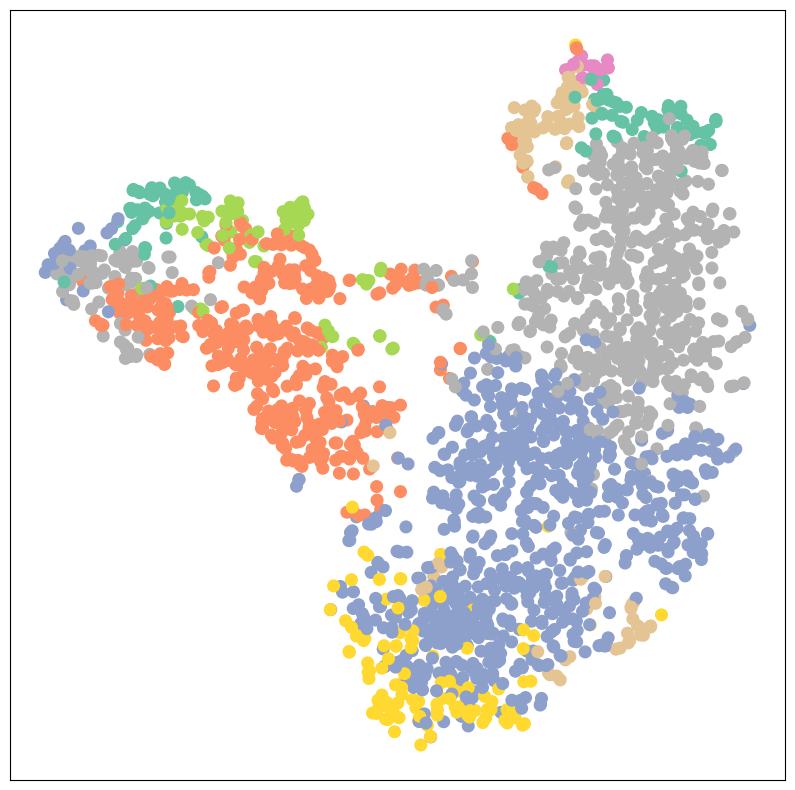

In [8]:
visualize(torch.tensor(embeddings2), color=cluster_labels)
# visualize(torch.tensor(embeddings2), color=np.zeros([1,graph_num]))

# Clustering the Graphs:

In [10]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Load the embedded graph data
# embeddings = np.load('embeddings.npy')

# Set the number of clusters
num_clusters = 15

# Initialize the GMM model
gmm = GaussianMixture(n_components=num_clusters)

# Fit the GMM model to the embedded data
gmm.fit(embeddings2)

# Predict the cluster labels for the embedded data
cluster_labels = gmm.predict(embeddings2)
print(cluster_labels)

[ 3 11 12 ...  0  3  3]


In [136]:
!pip install -q hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [143]:
import hdbscan

# Assuming your 6x1000 array is called `embedded_graph`
# Transpose the array so that each row represents a data point and each column represents a feature
embedded_graph = embeddings2

# Cluster the data using HDBSCAN
clusterer = hdbscan.HDBSCAN()
cluster_labels2 = clusterer.fit_predict(embedded_graph)

# Print the number of clusters found
num_clusters = len(set(cluster_labels2)) - (1 if -1 in cluster_labels2 else 0)
print(f"Number of clusters: {num_clusters}")

# Print the cluster labels for each data point
print("Cluster labels:")
print(cluster_labels2)

Number of clusters: 3
Cluster labels:
[ 2  2 -1 ...  2  2  2]


# Analysis:

transition matrix:

In [48]:
states = cluster_labels
# Get unique state values
unique_states = np.unique(cluster_labels)

# Calculate the size of the transition matrix
matrix_size = 15

# Create an empty transition matrix
transition_matrix = np.zeros((matrix_size, matrix_size))

# Calculate the number of transitions between each pair of states
for i in range(graph_num - 1):
    current_state = states[i]
    next_state = states[i + 1]
    current_state_index = np.where(unique_states == current_state)[0][0]
    next_state_index = np.where(unique_states == next_state)[0][0]
    transition_matrix[current_state_index][next_state_index] += 1

# Normalize the transition matrix
row_sums = np.sum(transition_matrix, axis=1)
transition_matrix = np.divide(transition_matrix, row_sums[:, np.newaxis])

print(transition_matrix)

[[0.         0.         0.         0.         0.0625     0.125
  0.         0.         0.0625     0.         0.         0.
  0.         0.         0.75      ]
 [0.         0.         0.         0.07142857 0.07142857 0.19047619
  0.         0.07142857 0.         0.         0.         0.
  0.02380952 0.02380952 0.54761905]
 [0.         0.03030303 0.03030303 0.03030303 0.06060606 0.09090909
  0.         0.06060606 0.         0.         0.         0.
  0.         0.06060606 0.63636364]
 [0.         0.01851852 0.01851852 0.02777778 0.0462963  0.15740741
  0.         0.07407407 0.01851852 0.01851852 0.02777778 0.
  0.00925926 0.05555556 0.52777778]
 [0.01470588 0.01470588 0.02941176 0.05882353 0.01470588 0.19117647
  0.         0.04411765 0.         0.         0.04411765 0.
  0.01470588 0.01470588 0.55882353]
 [0.00950119 0.01425178 0.00475059 0.04750594 0.02375297 0.18764846
  0.0023753  0.0807601  0.0023753  0.00712589 0.02612827 0.
  0.04038005 0.04750594 0.50593824]
 [0.         0.      

histogram:

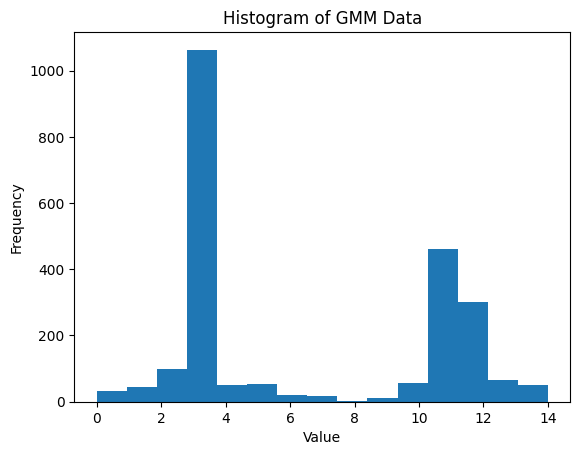

NameError: ignored

In [11]:
plt.hist(cluster_labels, bins=15)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of GMM Data')
plt.show()

plt.hist(label_list, bins=15)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('PennAction Labels')
plt.show()

transition graph:

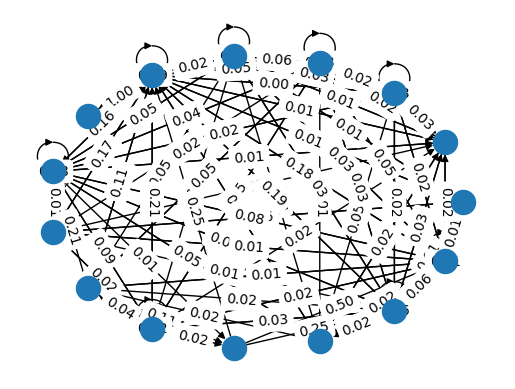

In [53]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# define the transition matrix
P = transition_matrix

# create a directed graph
G = nx.DiGraph()

# add nodes to the graph
for i in range(P.shape[0]):
    G.add_node(i)

# add edges to the graph
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P[i,j] > 0:
            G.add_edge(i, j, weight=P[i,j])

# set the positions of the nodes in the graph
pos = nx.circular_layout(G)

# draw the nodes and edges of the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# add edge labels to the graph
edge_labels = {(i, j): "{:.2f}".format(P[i,j]) for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# display the graph
plt.axis("off")
plt.show()


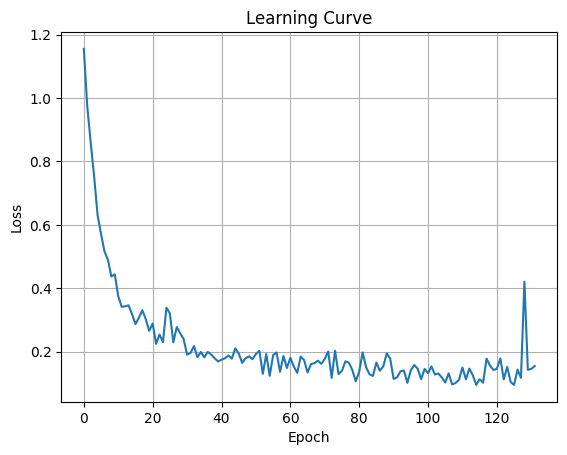

In [85]:
plt.plot(loss_list)
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [134]:
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
embedded_3d = tsne.fit_transform(embeddings2)

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embedded_2d = tsne.fit_transform(embeddings2)

In [ ]:
np.save('/content/drive/MyDrive/SocioSent/embedded_2d.npy', embedded_2d)
np.save('/content/drive/MyDrive/SocioSent/embedded_3d.npy', embedded_3d)

In [ ]:
embedded_3d = np.load('/content/drive/MyDrive/SocioSent/embedded_3d.npy')
embedded_2d = np.load('/content/drive/MyDrive/SocioSent/embedded_2d.npy')

In [ ]:
import collections

labels = []#np.zeros([1,Xs.shape[1]])
embeds = []
embeds_3d = []
embeds_2d = []
n = 120
len = df.shape[0]
overlap = 0.5
step_size = 10

# count = collections.Counter(my_list)
# most_common = count.most_common(1)[0][0]

for i in range(0, 120):
  idx = 0
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])

for i in range(120, len-120):
  step = i // step_size
  idx = step - 4
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])

for i in range(len-120, len):
  # step = len - 120 // step_size
  idx = len - 120
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = 0 #count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[2,:])
  embeds_2d.append(embedded_2d[2,:])
  embeds_3d.append(embedded_3d[2,:])

# for _ in range(int(n*0.25)):
#     labels.append(cluster_labels[0])
#     embeds.append(embeddings2[0,:])

# for i in range(graph_num):
#   for _ in range(int(n*0.5)):
#     labels.append(cluster_labels[i])
#     embeds.append(embeddings2[i,:])

# for _ in range(int(50)):
#     labels.append(cluster_labels[graph_num-1])
#     embeds.append(embeddings2[graph_num-1,:])

  # labels[idx*n:(idx*n+n)] = la*np.ones([1,graph_num])
# labels[idx:idx+n] = la

embeds_3d = np.array(embeds_3d)
embeds_2d = np.array(embeds_2d)

In [ ]:
print(labels[1000:1500])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
df = pd.DataFrame(labels)
df.to_csv('/content/drive/MyDrive/SocioSent/frame_lablels.csv', index=False)

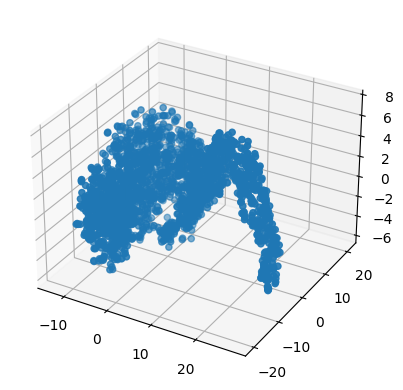

In [135]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# assume your embedded graphs are stored in a numpy array called 'embedded_graphs'
# with shape (6, 927)
# embedded_graphs = embeddings2.T

# reduce the dimensionality of the embedded graphs to 3D using t-SNE
# tsne = TSNE(n_components=3, perplexity=30, random_state=0)
# embedded_3d = tsne.fit_transform(embedded_graphs.T)

# create a 3D scatter plot of the embedded graphs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(embedded_3d[:,0], embedded_3d[:,1], embedded_3d[:,2])
plt.show()


In [27]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, label_list, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the weighted F1 score
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("Weighted F1 score:", f1_weighted)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Weighted F1 score: 0.3554867492126989
Accuracy: 0.37249283667621774


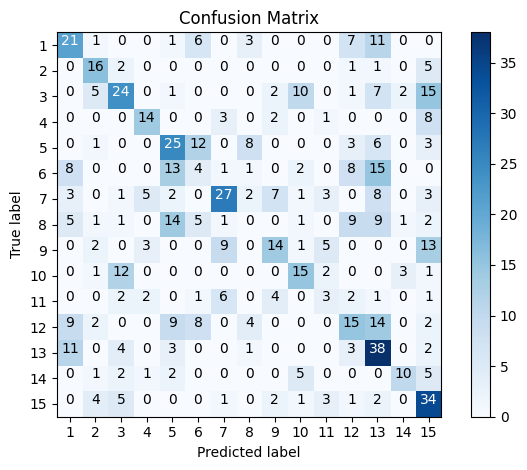

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example ground truth and predicted labels
y_true = y_test

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Define the class labels
class_names = [str(i+1) for i in range(15)]

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names)
plt.show()


KeyError: ignored

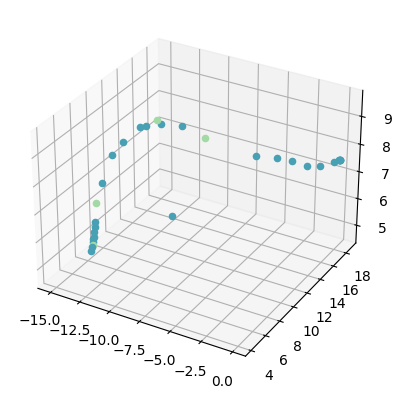

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# assume your embedded graphs are stored in a numpy array called 'embedded_graphs'
# with shape (6, 927)
embedded_graphs = embeddings2.T

# reduce the dimensionality of the embedded graphs to 3D using t-SNE
# tsne = TSNE(n_components=3, perplexity=30, random_state=0)
# embedded_3d = tsne.fit_transform(embedded_graphs.T)

# create a 3D scatter plot of the embedded graphs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

unique_labels = set(cluster_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, 8))
color_dict = {label: color for label, color in zip(unique_labels, colors)}

# plot each point with its corresponding color
for i in range(graph_num):
    label = cluster_labels[i]
    ax.scatter(embedded_3d[i,0], embedded_3d[i,1], embedded_3d[i,2], color=color_dict[label])

# ax.scatter(embedded_3d[:,0], embedded_3d[:,1], embedded_3d[:,2], color=cluster_labels)
plt.show()


In [ ]:
embeds = np.array(embeds)

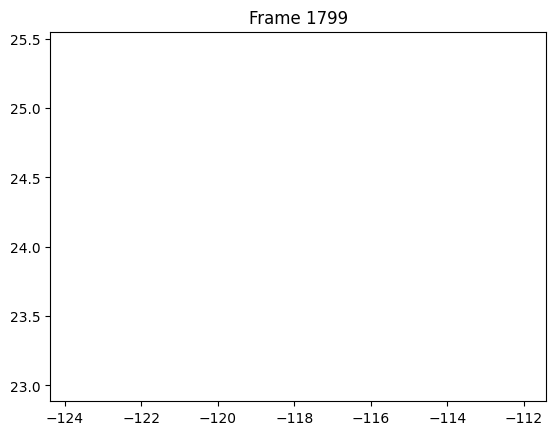

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# function to create 2D scatter plot for each frame
def plot_scatter(frame_idx, states, embeddings):
    plt.cla()  # clear previous plot
    # get x, y coordinates of embeddings for current frame
    x = embeddings[frame_idx, 0]
    y = embeddings[frame_idx, 1]
    # get the behavioral state label for current frame
    state = states[frame_idx]
    # plot the scatter plot with different color based on the behavioral state label
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']
    plt.scatter(x, y, c=colors[state])
    plt.title("Frame {}".format(frame_idx))

# function to create the gif animation
def create_animation(states, embeddings, fps):
    fig = plt.figure()
    anim = animation.FuncAnimation(fig, plot_scatter, frames=embeddings.shape[0], fargs=(states, embeddings))
    anim.save('scatter_animation.gif', writer='imagemagick', fps=fps)

# create animation with 30 fps
create_animation(labels, embedded_2d[0:1800,:], fps=30)


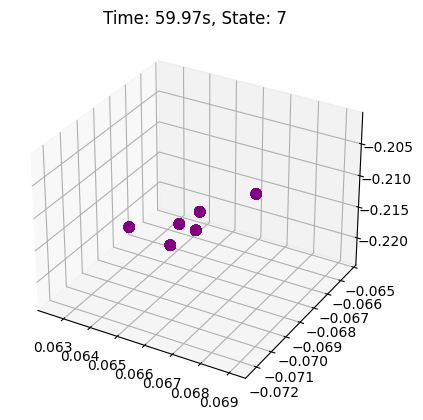

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def plot_embedding_states(embedding, states, fps=30, save_path='embedded.gif'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # colors = ['red', 'blue', 'green', 'yellow'] # add more colors if 
    colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'purple']
    state_to_color = {0: colors[0], 1: colors[1], 2: colors[2], 3: colors[3]} # map state label to color

    x = embedding[:,0]
    y = embedding[:,1]
    z = embedding[:,2]

    frames = len(x)
    sc = ax.scatter(x[0], y[0], z[0], color=colors[states[0]], s=50)

    def update_graph(num):
        sc._offsets3d = (x[:num], y[:num], z[:num])
        sc.set_color(colors[states[num]])
        ax.set_title(f'Time: {num/fps:.2f}s, State: {states[num]}')
        return sc,

    ani = animation.FuncAnimation(fig, update_graph, frames=frames, interval=1000/fps, blit=False)

    ani.save(save_path, writer='pillow')

# Usage example
embedding = embeds[0:1800, :] # 2D embedding, shape: (num_frames, 2)
states = labels # list of state labels, length: num_frames
plot_embedding_states(embedding, states)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Define the fade-out duration in frames (7 minutes)
FADE_OUT_DURATION = 7 * 60 * 30

# Define the colors for each label
LABEL_COLORS = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray'
}

# Define the labels
LABELS = ['State {}'.format(i) for i in range(8)]

# Define the figure and axes for the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('State Space Trajectory')

# Initialize the fade-out mask
fade_out_mask = np.zeros((30*60*30,), dtype=float)

# Define the function for updating the plot
def update_plot(frame_num):
    # Get the current label and coordinates
    label = labels[frame_num]
    coord = embeds.T[:, frame_num]
    coords = embeds.T

    # Update the fade-out mask
    fade_out_mask[frame_num:] += 1
    fade_out_mask[fade_out_mask > FADE_OUT_DURATION] = FADE_OUT_DURATION
    
    # Plot the current point
    ax.scatter(coord[0], coord[1], coord[2], c=LABEL_COLORS[label], alpha=0.8, s=50)
    
    # Plot the past points
    for i in range(frame_num - FADE_OUT_DURATION, frame_num):
        if i >= 0:
            alpha = 0.8 - fade_out_mask[frame_num - i] / FADE_OUT_DURATION
            ax.scatter(coords[0, i], coords[1, i], coords[2, i], c=LABEL_COLORS[labels[i]], alpha=alpha, s=50)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
    
    # Update the title with the current frame number and label
    t = frame_num / 30
    # ax.set_title('Time: {:.1f}s, State: {}'.format(t, states[frame]))
    ax.set_title('State Space Trajectory (Frame: {} / Label: {} / Time: {:.1f}s)'.format(frame_num, LABELS[label], t))
    
    # Return the plot objects
    return ax

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=30*60*30, interval=33.3, blit=False)

# Save the animation as a GIF
ani.save('state_space_trajectory.gif', writer='imagemagick', fps=30)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def fade(alpha, t_start, t_curr):
    age = t_curr - t_start
    if age < 0:
        return 1
    elif age < 300:
        return alpha
    elif age < 420:
        return alpha * (420 - age) / 120
    else:
        return 0

def update(frame, states, embeddings):
    ax.clear()
    t = frame / 30
    ax.set_title('Time: {:.1f}s, State: {}'.format(t, states[frame]))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    for i, state in enumerate(states):
        if i <= frame:
            alpha = fade(0.7, i/30, t)
            if alpha > 0:
                ax.scatter(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2],
                           color=plt.cm.tab10(state / 10.), alpha=alpha, s=20)
    return []

# Example inputs
embeddings = embeds_3d
states = labels

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ani = animation.FuncAnimation(fig, update, frames=20000, fargs=(states, embeddings),
                              interval=33.33, blit=True)

# Save animation as GIF
ani.save('/content/drive/MyDrive/SocioSent/embedded_states.gif', writer='pillow', fps=30)


In [ ]:

ani.save('embedded_states.mp4', writer='pillow', fps=30)

In [ ]:
np.savetxt('/content/drive/MyDrive/SocioSent/embeds_3d.csv', embeds_3d, delimiter=',')
np.savetxt('/content/drive/MyDrive/SocioSent/embeds_2d.csv', embeds_2d, delimiter=',')
np.savetxt('/content/drive/MyDrive/SocioSent/labels.csv', labels, delimiter=',')